Vamos a usar la herramienta Cirq de Google para crear y ejecutar algunos circuitos cuánticos.

In [28]:
import cirq
import cirq_google

Empezamos definiendo qubits de diferentes maneras

In [29]:
# Primera forma - Creamos qubits etiquetados con NamedQubit
q0 = cirq.NamedQubit('source')
q1 = cirq.NamedQubit('target')

# Segunda forma - creamos qubits etiquetados por su posición en un array
# o individualmente
q3 = cirq.LineQubit(3)
q0, q1, q2 = cirq.LineQubit.range(3)

# Tercera forma - Creamos los qubits en un mallado rectangular. Cada uno
# se identifica por dos números enteros que son sus coordenadas en el mallado.
q4_5 = cirq.GridQubit(4, 5)

# Aquí creamos un mallado 4x4 con coordenadas desde (0, 0) hasta (3, 3)
qubits = cirq.GridQubit.square(4)

Existen conjuntos de qubits previamente creados por parte de Google denominados "Dispositivos". Para acceder a ellos usamos cirq.Device. A continuación mostramos cirq_google.Sycamore que cuenta con 54 qubits en dispuestos en forma de "diamante".

In [30]:
print(cirq_google.Sycamore)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

Otro aspecto importante de los circuitos cuánticos son los portones cuánticos y las operaciones que se pueden llevar a cabo sobre los qubits. Proponemos a continuación algunos ejemplos.

In [31]:
# Portones CNOT y Pauli-Z
cnot_gate = cirq.CNOT
pauli_z = cirq.Z

# Portones que obtienen la raíz cuadrada
sqrt_x_gate = cirq.X ** 0.5

# Portones que admiten parámetros
sqrt_sqrt_y_gate = cirq.YPowGate(exponent = 0.25)

# Creamos dos qubits en una línea
q0, q1 = cirq.LineQubit.range(2)

# Aplicamos algunas operaciones
# Pauli-Z
z_op = cirq.Z(q0)
# CNOT q0 y q1
not_op = cirq.CNOT(q0, q1)
# SWAP sqrt
sqrt_iswap_op = cirq.SQRT_ISWAP(q0, q1)

# Se pueden reutilizar los portones que hemos guardado como variables
# previamente.
cnot_op = cnot_gate(q0, q1)
pauli_z_op = pauli_z(q0)
sqrt_x_op = sqrt_x_gate(q0)
sqrt_sqrt_y_op = sqrt_sqrt_y_gate(q0)

Los circuitos en cirq utilizan los Moment para controlar en que punto del circuito se realiza cada operación o se coloca cada portón. Vamos a ver algunos ejemplos.

In [32]:
circuit = cirq.Circuit()
qiubits = cirq.LineQubit.range(3)
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.H(qubits[1]))
circuit.append(cirq.H(qubits[2]))
print(circuit)

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───


Esto también se puede hacer con listas de compresión

In [33]:
circuit = cirq.Circuit()
ops = [cirq.H(q) for q in cirq.LineQubit.range(3)]
circuit.append(ops)
print(circuit)

0: ───H───

1: ───H───

2: ───H───


Si nos fijamos los portones Hadamard se colocan lo más a la izquierda posible, es decir, en el mismo Moment. Las operaciones que se apliquen a los mismos qubits se pondrán en orden secuencial, es decir, se colocan en Moments consecutivos. Veamos un ejemplo.

In [34]:
print(cirq.Circuit(cirq.SWAP(q, q + 1) for q in cirq.LineQubit.range(3)))

0: ───×───────────
      │
1: ───×───×───────
          │
2: ───────×───×───
              │
3: ───────────×───


Si queremos evitar que las operaciones se coloquen lo más a la izquierda posible podemos crear el circuito pasándole un iterable de Moments como en el siguiente ejemplo.

In [35]:
print(cirq.Circuit(cirq.Moment([cirq.H(q)]) for q in cirq.LineQubit.range(3)))

0: ───H───────────

1: ───────H───────

2: ───────────H───


Cuando usamos circuitos cuánticos reales es posible que existan ciertas restricciones a nivel de Hardware. Se utilizan objetos de tipo Device que especifican estas restricciones y evitan la existencia de operaciones iliegales en el circuito. Veamos un ejemplo que lanza una excepción con el Sycamore Device que hemos visto previamente. 

In [36]:
# Creamos unos qubits en un mallado
q0 = cirq.GridQubit(5, 6)
q1 = cirq.GridQubit(5, 5)
q2 = cirq.GridQubit(4, 5)

# Creamos dos operaciones con el portón Sycamore. Estas operaciones
# actuan sobre qubits adyacentes (q0, q1) y no adyacentes (q1, q2)
adjacent_op = cirq_google.SYC(q0, q1)
nonadjacent_op = cirq_google.SYC(q0, q2)

# Si aplicamos el operador adyacente se genera un circuito válido que no da problemas
working_circuit = cirq.Circuit()
working_circuit.append(adjacent_op)
valid = cirq_google.Sycamore.validate_circuit(working_circuit)

# Si aplicamos el no adyacente generamos un circuito no válido y se 
# genera una excepción.
bad_circuit = cirq.Circuit()
bad_circuit.append(nonadjacent_op)
try:
    cirq_google.Sycamore.validate_circuit(bad_circuit)
except ValueError as e:
    print(e)

Operation does not use valid qubit target: SYC((5, 6), (4, 5)).


Vamos a pasar ahora a simular un circuito usando Simulator(). 

In [37]:
# Creamos un estado de bell 
# 1/sqrt(2) * ( |00⟩ + |11⟩ )
bell_circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0, q1))

#Inicializamos el simulador
s = cirq.Simulator()

print('Simulate the circuit:')
results = s.simulate(bell_circuit)
print(results)

# Para muestrear medimos los resultados al final
bell_circuit.append(cirq.measure(q0, q1, key='result'))

# Ejecutamos varias veces para obtener un muestreo significativo
samples = s.run(bell_circuit, repetitions=1000)

Simulate the circuit:
measurements: (no measurements)

qubits: (cirq.LineQubit(0), cirq.LineQubit(1))
output vector: 0.707|00⟩ + 0.707|11⟩

phase:
output vector: |⟩


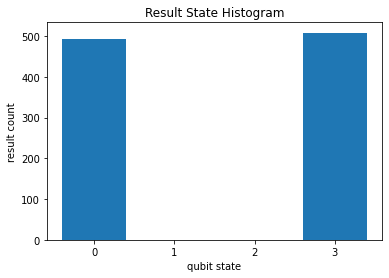

In [38]:
import matplotlib.pyplot as plt
cirq.plot_state_histogram(samples, plt.subplot())
plt.show()

Este histograma sería equivalente a leer $|00\rangle$ y $|11\rangle$ aproximadamente el 50% de las veces cada uno y leer 0 veces los estados $|10\rangle$ y $|01\rangle$. Si queremos eliminar las entradas con 0 elementos hacemos lo siguiente.

Counter({3: 508, 0: 492})


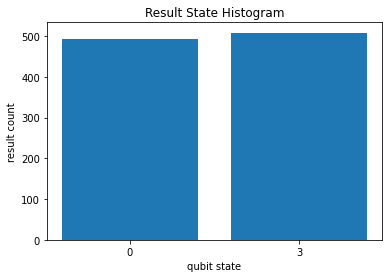

In [39]:
# Obtenemos los conteos a partir del histograma
counts = samples.histogram(key='result')
print(counts)

# Graficamos los conteos en lugar de los resultados del circuito
cirq.plot_state_histogram(counts, plt.subplot())
plt.show()

Hasta aquí tendríamos cubierto con cirq aproximadamente el mismo contenido que hemos visto con qiskit. Para completar el notebook, vamos a tratar de replicar el ejercicio que vimos con qiskit pero usando Cirq. Comenzamos definiendo los qubits y el circuito a usar.

In [40]:
# Creamos el circuito
circuit = cirq.Circuit()
# Creamos dos qubits
qb = cirq.LineQubit.range(2)
# Agregamos los qubits al circuito
# Aplicamos una puerta Hadamard sobre q0
circuit.append(cirq.H(qb[0]))
# Aplicamos una puerta CNOT (C-X) con q0 como qubit de control y 
# q1 como qubit objetivo
circuit.append(cirq.CNOT(qb[0], qb[1]))
# Mostramos el circuito creado
print(circuit)

0: ───H───@───
          │
1: ───────X───


Del diagrama anterior puede verse como ya tenemos el circuito creado. Procedemos ahora a crear un Simulator() y simular el circuito.

In [41]:
#Inicializamos el simulador
s = cirq.Simulator()

print('Simulate the circuit:')
results = s.simulate(circuit)
print(results)

# Para muestrear medimos los resultados al final
circuit.append(cirq.measure(qb[0], qb[1], key='result'))

# Ejecutamos varias veces para obtener un muestreo significativo
samples = s.run(bell_circuit, repetitions=1000)

Simulate the circuit:
measurements: (no measurements)

qubits: (cirq.LineQubit(0), cirq.LineQubit(1))
output vector: 0.707|00⟩ + 0.707|11⟩

phase:
output vector: |⟩


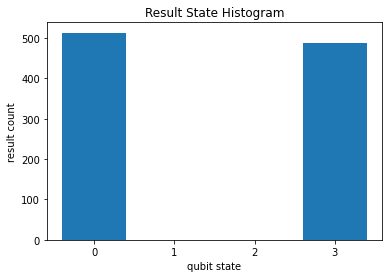

In [42]:
cirq.plot_state_histogram(samples, plt.subplot())
plt.show()

De nuevo, leemos únicamente los estados $|00\rangle$ y $|11\rangle$ por los mismos motivos que ya explicamos en el notebook correspondiente a qiskit. Seguimos la misma estrategia que en el caso anterior para eliminar las entradas con 0 elementos. 

Counter({0: 513, 3: 487})


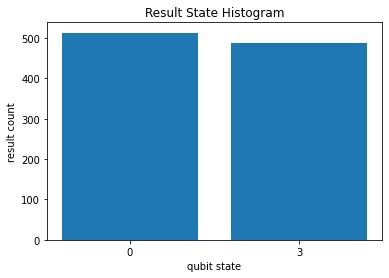

In [43]:
# Obtenemos los conteos a partir del histograma
counts = samples.histogram(key='result')
print(counts)

# Graficamos los conteos en lugar de los resultados del circuito
cirq.plot_state_histogram(counts, plt.subplot())
plt.show()